In [310]:
import pandas as pd
import numpy as np
import itertools as it
import functools as ft
import multiprocessing as mp
from time import time

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.coordinate_descent import LinearModelCV
from sklearn.linear_model import ElasticNetCV
from sklearn.base import RegressorMixin
from sklearn.linear_model.base import LinearModel
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import *

from scipy.stats import norm
from scipy.stats.mstats import gmean

from tqdm import tqdm

from glmnet_py import glmnet, glmnetPredict

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# define data dictionaries
X = {}
y = {}
targ = {}
ref = {}

for t in ['train', 'dev', 'test']:
    dat = pd.read_csv('../data/modelInputs/standardizedGrowth/' + t + '.csv', index_col=0)
    ref[t] = dat[['Drug', 'Concentration']]
    y[t] = dat['Growth']
    X[t] = dat[['Cellline'] + list(dat.columns[4:])]
    
for t in ['train', 'dev', 'test']:
    targ[t] = norm.ppf((y[t]+1.)/2.)
    targ[t][targ[t] > 8] = 8
    targ[t][targ[t] < -8] = -8

In [3]:
dummified_celllines = pd.get_dummies(X['train']['Cellline'].append(X['dev']['Cellline']).append(X['test']['Cellline']))

for t in ['train', 'dev', 'test']:
    X[t] = X[t].drop('Cellline', axis=1).merge(dummified_celllines, how='left', left_index=True, right_index=True)

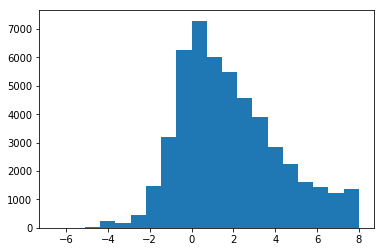

In [4]:
plt.hist(targ['train'], bins=20)
plt.show()

In [6]:
def weighter(y, alpha=0):
    '''
    When alpha is set to 0, this returns the inverse class distributions for weights
    
    Else alpha of geomean ratio is penalized
    '''
    unique = np.unique(y).tolist()
    ratios = len(y) / (2. * np.bincount(np.array(y, dtype=np.int64)))
    
    ratios = alpha * gmean(ratios) + (1 - alpha) * ratios
    
    return dict(zip(unique, ratios))

In [59]:
3e-4

0.0003

In [114]:
# set parameters
n_jobs = 15
clf = None
threshes=[1e-12, 1e-3, 1e-2, 5e-2]
clf_loss = ['modified_huber']
l1_ratios=[0.1, 0.5, 0.9, 0.99]
clf_alphas = [3e-5, 1e-4, 3e-4, 1e-3, 3e-5]

def thresholder(thresh, arr):
    return (arr > 1- thresh) * 1.

clf_transformer = ft.partial(thresholder, 1e-12)

def weight_hash_helper(weights):
    if type(weights) == dict:
        return tuple(list(weights.values()))
    else:
        return weights

clf_class_weights = [None, 'balanced', weighter(clf_transformer(y['train']), .25), weighter(clf_transformer(y['train']), .5), weighter(clf_transformer(y['train']), .75)]

In [115]:
clf_holder = {}
val_scores = {}
for loss in clf_loss:
    for weights in clf_class_weights:
        for ratio in l1_ratios:
            for alpha in clf_alphas:
                clf_holder[(loss, weight_hash_helper(weights), ratio, alpha)] = BaggingClassifier(base_estimator=SGDClassifier(penalty='elasticnet',                   
                                                                                                    loss=loss, 
                                                                                                    learning_rate='optimal',
                                                                                                    class_weight=weights, 
                                                                                                    l1_ratio=ratio,
                                                                                                    alpha=alpha,
                                                                                                    random_state=1920),
                                        n_estimators=30,
                                        max_samples=0.632,
                                        n_jobs=n_jobs)

In [ ]:
# sample fitter
with tqdm(total = len(threshes) * len(clf_holder)) as pbar:
    for hyper, clf in clf_holder.items():
        for thresh in threshes:
            # make a transformer dynamically
            clf_transformer = ft.partial(thresholder, thresh)

            clf.fit(X['train'].sample(frac=0.02, random_state=1920), clf_transformer(pd.Series(y['train']).sample(frac=0.02, random_state=1920)))

            try:
                val_scores[hyper + (thresh,)] = average_precision_score(clf_transformer(pd.Series(y['dev']).sample(frac=0.02, random_state=1920)), clf.predict(X['dev'].sample(frac=0.02, random_state=1920)))
            except:
                pass
            
            pbar.update(1) 

In [68]:
pd.Series(val_scores).reset_index().sort_values(0, ascending=False).head(10)

,level_0,level_1,level_2,level_3,level_4,0
17,modified_huber,NaN,0.50,0.00030,0.05,0.729537
53,modified_huber,NaN,0.99,0.00003,0.05,0.709343
137,modified_huber,balanced,0.99,0.00030,0.05,0.707071
29,modified_huber,NaN,0.90,0.00003,0.05,0.704918
335,modified_huber,"(2.2938134427437293, 6.201550439409223)",0.90,0.00100,0.05,0.702875
65,modified_huber,NaN,0.99,0.00030,0.05,0.701754
35,modified_huber,NaN,0.90,0.00010,0.05,0.699659
347,modified_huber,"(2.2938134427437293, 6.201550439409223)",0.99,0.00010,0.05,0.692308
311,modified_huber,"(2.2938134427437293, 6.201550439409223)",0.50,0.00100,0.05,0.690691
59,modified_huber,NaN,0.99,0.00010,0.05,0.690236


In [117]:
with tqdm(total = len(threshes) * len(clf_holder)) as pbar:
    for hyper, clf in clf_holder.items():
        for thresh in threshes:
            # make a transformer dynamically
            clf_transformer = ft.partial(thresholder, thresh)

            clf.fit(X['train'], clf_transformer(y['train']))

            preds = clf.predict(X['dev'])
            
            ap_score = average_precision_score(clf_transformer(y['dev']), preds)
            auc_score = roc_auc_score(clf_transformer(y['dev']), preds)
            acc_score = accuracy_score(clf_transformer(y['dev']), preds)
            f1 = f1_score(clf_transformer(y['dev']), preds)
            r2 = pearsonr(clf_transformer(y['dev']), preds)[0]
            
            val_scores[hyper + (thresh,)] = (ap_score, auc_score, acc_score, f1, r2)
            
            pbar.update(1)

100%|██████████| 320/320 [24:12<00:00,  4.27s/it]


In [136]:
res = pd.DataFrame(pd.Series(val_scores))
res = pd.concat([res.drop(0, axis=1).reset_index(), pd.DataFrame(list(zip(*res[0]))).T], axis=1)
res.columns = ['Loss', 'Weights', 'L1_Ratio', 'Alpha', 'Thresh', 'AP_score', 'ROC_AUC', 'Accuracy', 'F1_score', 'R2']
res.to_csv('../results/validation_scores.csv', index=False)

In [152]:
thresh = 1e-12
clf_transformer = ft.partial(thresholder, thresh)

clf =  BaggingClassifier(base_estimator=SGDClassifier(penalty='elasticnet',
                                                      loss='modified_huber',
                                                      learning_rate='optimal',
                                                      class_weight=None,
                                                      l1_ratio=0.5,
                                                      alpha=1e-3,
                                                      random_state=1920),
                         n_estimators=30,
                         max_samples=0.632,
                         n_jobs=n_jobs)

clf.fit(X['train'], clf_transformer(y['train']))

preds = clf.predict(X['dev'])

print(average_precision_score(clf_transformer(y['dev']), preds))
print(roc_auc_score(clf_transformer(y['dev']), preds))
print(fbeta_score(clf_transformer(y['dev']), preds, beta=0.5))
print(accuracy_score(clf_transformer(y['dev']), preds))

0.6829386621167111
0.8092298849262088
0.754281719678434
0.8058361391694725


In [359]:
agg_dat = pd.concat([X['train'], X['dev'], X['test']])
agg_dat[['Drug', 'Concentration']] = pd.concat([ref['train'], ref['dev'], ref['test']])
agg_dat['Target'] = np.hstack([targ['train'], targ['dev'], targ['test']])
agg_dat['Growth'] = np.hstack([y['train'], y['dev'], y['test']])
agg_dat = agg_dat[list(agg_dat.columns[-4:]) + list(agg_dat.columns[:-4])]
agg_dat.head()

,Drug,Concentration,Target,Growth,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,...,uacc812,uacc893,umc11,umuc3,vmrclcd,wm115,wm2664,yapc,zr751,zr75b
53257,silmitasertib,3.00,-0.426184,-0.330026,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
42989,osi027,0.03,2.489425,0.987205,0.0,0.000000,0.000000,0.0,0.076540,0.0,...,0,0,0,0,0,0,0,0,0,0
36715,mgcd265,0.30,3.085930,0.997971,0.0,-0.367669,-0.212716,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
35826,masitinib,1.00,0.895365,0.629408,0.0,-0.478263,-0.317027,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
43312,osi027,30.00,-0.056795,-0.045292,0.0,0.000000,0.000000,0.0,-9.642757,0.0,...,0,0,0,0,0,0,0,0,0,0


In [360]:
agg_dat.to_csv('../data/agg_growth.csv')

In [361]:
### write predictions
thresh = 1e-12
clf_transformer = ft.partial(thresholder, thresh)

clf =  BaggingClassifier(base_estimator=SGDClassifier(penalty='elasticnet',
                                                      loss='modified_huber',
                                                      learning_rate='optimal',
                                                      class_weight='balanced',
                                                      l1_ratio=0.5,
                                                      alpha=1e-3,
                                                      random_state=1920),
                         n_estimators=30,
                         max_samples=0.632,
                         n_jobs=15)

clf.fit(agg_dat.values[:, 5:], clf_transformer(agg_dat.values[:, 2]))

preds = clf.predict_proba(agg_dat.values[:, 5:])

In [362]:
pd.DataFrame(preds, index=agg_dat.index).to_csv('../results/best_roc_auc_proba.csv')

In [363]:
### write predictions
thresh = 5e-2
clf_transformer = ft.partial(thresholder, thresh)

clf =  BaggingClassifier(base_estimator=SGDClassifier(penalty='elasticnet',
                                                      loss='modified_huber',
                                                      learning_rate='optimal',
                                                      class_weight=None,
                                                      l1_ratio=0.5,
                                                      alpha=1e-3,
                                                      random_state=1920),
                         n_estimators=30,
                         max_samples=0.632,
                         n_jobs=15)

clf.fit(agg_dat.values[:, 4:], clf_transformer(agg_dat.values[:, 2]))

preds = clf.predict_proba(agg_dat.values[:, 4:])

In [364]:
pd.DataFrame(preds, index=agg_dat.index).to_csv('../results/best_ap_score_proba.csv')

In [378]:
print(pearsonr(preds[:,1]>0.7, agg_dat['Growth']>1-5e-2))
accuracy_score(y_true=agg_dat['Growth']>1-5e-2, y_pred=(preds[:,1]>0.5)*1.)

(0.5984111517803943, 0.0)


0.7537679579271421

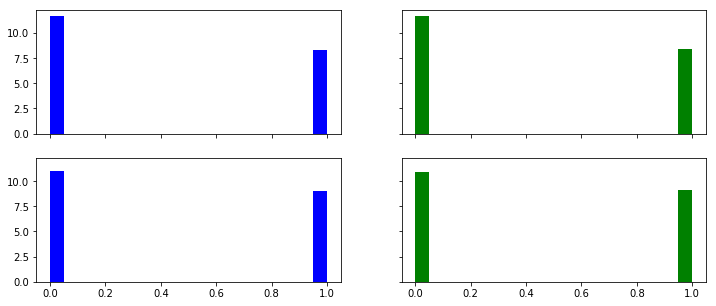

In [142]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2, nrows=2, sharey=True, sharex=True)

axes[0][0].hist(clf_transformer(y['train']), bins=20, density=True, color='b')
axes[0][1].hist(clf_transformer(y['dev']), bins=20, density=True, color='g')

p_train = clf.predict(X['train'])
p_dev = clf.predict(X['dev'])

axes[1][0].hist(p_train, bins=20, density=True, color='b')
axes[1][1].hist(p_dev, bins=20, density=True, color='g')

plt.show()

### Test Set Analysis

In [197]:
thresh = 5e-2
clf_transformer = ft.partial(thresholder, thresh)

clf =  BaggingClassifier(base_estimator=SGDClassifier(penalty='elasticnet',
                                                      loss='modified_huber',
                                                      learning_rate='optimal',
                                                      class_weight='balanced',
                                                      l1_ratio=0.5,
                                                      alpha=1e-4,
                                                      random_state=1920),
                         n_estimators=30, max_samples=0.632, n_jobs=n_jobs)
clf.fit(pd.concat([X['train'], X['dev']]), clf_transformer(pd.concat([y['train'], y['dev']])))

preds = clf.predict(X['test'])

print(roc_auc_score(clf_transformer(y['test']), preds))
print(f1_score(clf_transformer(y['test']), preds))
print(accuracy_score(clf_transformer(y['test']), preds))

0.7992610709960385
0.7699324940704251
0.7978194644861312


In [143]:
print(classification_report(clf_transformer(y['test']), preds))

              precision    recall  f1-score   support

         0.0       0.58      0.55      0.56      3626
         1.0       0.42      0.46      0.44      2611

   micro avg       0.51      0.51      0.51      6237
   macro avg       0.50      0.50      0.50      6237
weighted avg       0.52      0.51      0.51      6237



In [198]:
from scipy.stats import pearsonr
proba = clf.predict_proba(X['test'])

for i in range(11):
    print(pearsonr(clf_transformer(y['test']),(proba[:, 1] > i/10.)*1.)[0])

0.40450784370859333
0.5345509741745587
0.5756311455713544
0.5840434164739177
0.5957427343758674
0.5924272828870928
0.5802272474658623
0.550942804175156
0.518378319907015
0.4508527592154399
nan


/opt/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [296]:

class ElasticNet_py(LinearModel):
    '''
    Wrapper to reshape the pyglmnet to the 
    '''
    def __init__(self, kwarg_dict):
        self.kwargs = kwarg_dict
        self.model = None
        
    def fit(self, X, y):
        
        self.model = glmnet(X, y, 'gaussian', **kwarg_dict)
        
    def predict(self, X):
        preds = glmnetPredict(self.model, X)
        return preds.reshape(-1,1)
    
# we want to extend a regressor, although we have to consider adding in a classifier
class HierarchicalClfRegressor(LinearModel, RegressorMixin):
    

    def __init__(self, thresh, clf_loss='hinge', 
                 clf_cv_metric=f1_score, n_jobs=max(1, mp.cpu_count()-1), 
                 clf_l1_ratio=0.5, clf_cv=5, clf_class_weight='balanced', 
                 reg_cv=5, reg_l1_ratio=0.5, reg_alpha=0.1,
                 clf_ensemble_method='CV', prefit_clf=None, prefit_clf_proba=0.5,
                 use_pyglmnet=False, pyglmnet_groups=None,
                 reg_metric=mean_squared_error):
        '''
        n_jobs -- maximum number of jobs to use
        thresh -- used to determine the class targets for the clf
        
        '''
        self.thresh = thresh
        self.clf_ensemble_method = clf_ensemble_method
        
        self.clf_cv_metric = clf_cv_metric
        self.clf_loss = clf_loss
        self.clf_l1_ratio = clf_l1_ratio
        self.clf_cv = clf_cv
        self.clf_class_weight = clf_class_weight
        
        self.n_jobs = n_jobs
        
        if type(reg_l1_ratio) == list:
            self.reg_l1_ratio = reg_l1_ratio
        else:
            self.reg_l1_ratio = [reg_l1_ratio]
            
        if type(reg_alpha) == list:
            self.reg_alpha = reg_alpha
        else:
            self.reg_alpha = [reg_alpha]
            
        self.reg_cv = reg_cv
        
        self.clf_cross_val = None
        
        self.prefit_clf_proba = prefit_clf_proba
        self.prefit_clf = False
        
        if prefit_clf is not None:
            self.prefit_clf = True
            self.clf = prefit_clf
        elif self.clf_ensemble_method == 'CV':
            self.clf = SGDClassifier(n_jobs=self.n_jobs//self.clf_cv, penalty='elasticnet', loss=self.clf_loss,
                                     learning_rate='optimal', class_weight=self.clf_class_weight, l1_ratio=self.clf_l1_ratio)
        elif self.clf_ensemble_method == 'early_stopping':
            self.clf = SGDClassifier(n_jobs=self.n_jobs, penalty='elasticnet', loss=self.clf_loss,
                                     learning_rate='optimal', class_weight=self.clf_class_weight, l1_ratio=self.clf_l1_ratio,
                                     early_stopping=True, validation_fraction=.2, max_iter=10, tol=1e-6)
        else:
            self.clf = BaggingClassifier(base_estimator=SGDClassifier(penalty='elasticnet', loss=self.clf_loss, learning_rate='optimal', class_weight=self.clf_class_weight, l1_ratio=self.clf_l1_ratio),
                                        n_estimators=20, max_samples=0.632, oob_score=True, n_jobs=n_jobs)
            
        self.pyglmnet = use_pyglmnet
        self.pyglmnet_groups = pyglmnet_groups
        self.reg_metric= reg_metric
            
        if use_pyglmnet:
            self.reg = ElasticNetCV(l1_ratio=self.reg_l1_ratio, n_jobs=self.n_jobs//self.reg_cv, fit_intercept=False, cv=self.reg_cv)
        else:
            self.reg = None
        
        
    def fit(self, X, y=None, y_clf=None, y_reg=None, cv_groups=None):
        '''
        Either y or both y_clf and y_reg must be not None
        y_clf and y_reg are transformations of each other (same dimensions)
        '''
        if y is None:
            pass
        else:
            y_clf = y
            y_reg = y
        
        if self.prefit_clf:
            # extract the clf predictions
            clf_predictions = (self.clf.predict_proba(X)[:, 1] > self.prefit_clf_proba)*1.
            self.clf_mean_prediction = np.mean(y_reg[clf_predictions==1])
        else:
            # fit the classifier
            target = (y_clf >= 1. - self.thresh)*1.

            if self.clf_ensemble_method == 'CV':
                self.clf_cross_val = cross_validate(self.clf, X, target, scoring=make_scorer(self.clf_cv_metric),
                                                    cv=self.clf_cv, n_jobs=self.clf_cv,
                                                    return_estimator=True)

                max_clf_cv = np.argmax(self.clf_cross_val['test_score'])

                self.clf = self.clf_cross_val['estimator'][max_clf_cv]
            else:
                self.clf.fit(X, target)

            # extract the clf predictions
            clf_predictions = self.clf.predict(X)
        
            # estimate the clf best prediction for the y_reg
            self.clf_mean_prediction = np.mean(y_reg[clf_predictions==1])
        
        if self.pyglmnet:
            logo = LeaveOneGroupOut()
            self.num_splits = logo.get_n_splits(groups=cv_groups[clf_predictions==0])
            self.splits = logo.split(X[clf_predictions==0], y_reg[clf_predictions==0], cv_groups[clf_predictions==0])
            self.reg_cross_val = {}
            
            # perform cross validation for very l1, alpha value
            for l1_ratio in self.reg_l1_ratio:
                for alpha in self.reg_alpha:
                    #mod = cvWrapper_pyElasticNet(pyElasticNet(distr='gaussian', alpha=l1_ratio, reg_lambda=alpha, group=self.pyglmnet_groups))
                    mod = LinearRegression()
                    s = cross_validate(mod, X[clf_predictions==0].values, y_reg[clf_predictions==0], scoring=make_scorer(self.reg_metric),
                                       cv=self.splits, n_jobs=self.n_jobs, return_estimator=True)
                    
                    running_error = 0.0
                    running_count = 0
                    
                    # enumerate over the splits (variable size)
                    for idx, split_indices in enumerate(logo.split(X[clf_predictions==0], y_reg[clf_predictions==0], cv_groups[clf_predictions==0])):
                        count = split_indices[0].shape[0]
                        
                        # aggregate mse
                        running_error += count * s['test_score'][idx]
                        running_count += count
                        
                    s['agg_score'] = running_error/running_count
                    
                    self.reg_cross_val[(l1_ratio, alpha)] = s
            
        else:
            # use the clf to fit the class zero predictions with a linear model
            self.reg.fit(X[clf_predictions==0], y_reg[clf_predictions==0])
        
    def predict(self, X):
        # final predictions to output
        end_preds = np.zeros((X.shape[0]))
    
        # estimate with the clf predictors
        clf_preds = self.clf.predict(X)
        end_preds[clf_preds==1] = self.clf_mean_prediction
        
        # predict the clf_negatives
        reg_preds = self.reg.predict(X[clf_preds==0])
        end_preds[clf_preds==0] = reg_preds
        
        return end_preds
        

In [313]:
glmnetPredict(tmod, X['dev']).shape

(6237, 85)

In [303]:
tmod.predict(X['train'].values)

array([[0.4550801],
       [0.4550801],
       [0.4550801],
       ...,
       [0.4550801],
       [0.4550801],
       [0.4550801]])

In [298]:
mod = HierarchicalClfRegressor(thresh=0.05, n_jobs=15, reg_l1_ratio=0.5, reg_alpha=0.1, reg_metric=mean_squared_error, prefit_clf=clf, use_pyglmnet=True)

In [299]:
mod.fit(X['train'], y=targ['train'], cv_groups=ref['train']['Drug'])

In [172]:
clf.estimators_[0].coef_.shape

(1, 662)

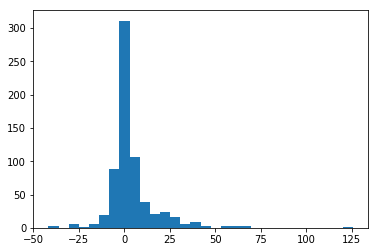

In [183]:
coef = np.mean(np.vstack([e.coef_ for e in clf.estimators_]), axis=0)
plt.hist(coef, bins=30)
plt.show()

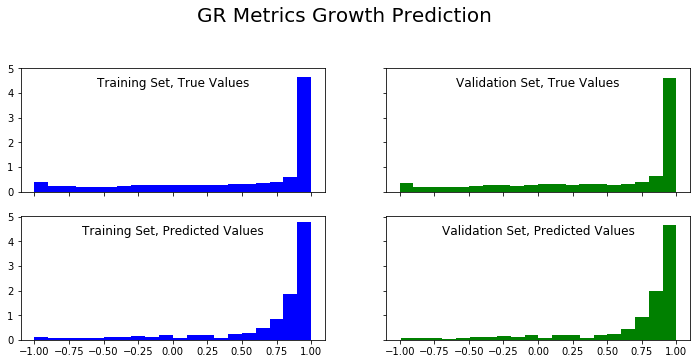

In [404]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2, nrows=2, sharey=True, sharex=True)

plt.suptitle('GR Metrics Growth Prediction', y=1.05, fontsize=20)
#plt.title('+1 = No Effect, 0 = Cytostatic response, -1 = Cell Death', y=1.0, fontsize=10)

axes[0][0].hist(y['train'], bins=20, density=True, color='b')
axes[0][0].set_title('Training Set, True Values', y=.8)

axes[0][1].hist(y['dev'], bins=20, density=True, color='g')
axes[0][1].set_title('Validation Set, True Values', y=.8)

axes[1][0].hist((norm.cdf(p_train)-.5)*2, bins=20, density=True, color='b')
axes[1][0].set_title('Training Set, Predicted Values', y=.8)

axes[1][1].hist((norm.cdf(p_dev)-.5)*2, bins=20, density=True, color='g')
axes[1][1].set_title('Validation Set, Predicted Values', y=.8)

plt.show()

In [431]:
print(np.corrcoef(y['train'], p_train))
print(np.corrcoef(y['dev'], p_dev))

[[1.         0.62368565]
 [0.62368565 1.        ]]
[[1.         0.61981648]
 [0.61981648 1.        ]]


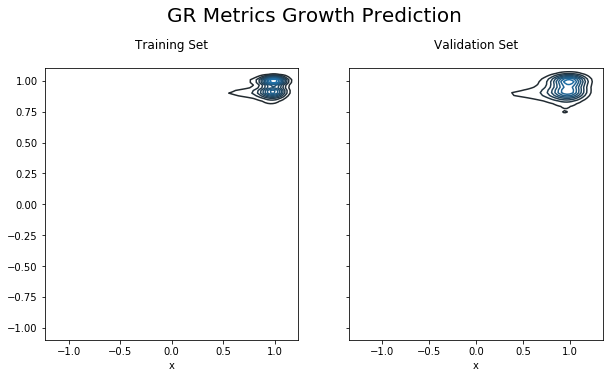

In [429]:
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)

plt.suptitle('GR Metrics Growth Prediction', y=1.05, fontsize=20)
#plt.title('+1 = No Effect, 0 = Cytostatic response, -1 = Cell Death', y=1.0, fontsize=10)

sns.kdeplot(y['train'], (norm.cdf(p_train)-.5)*2,ax=axes[0], shade=True)
axes[0].set_title('Training Set', y=1.05)

sns.kdeplot(y['dev'], (norm.cdf(p_dev)-.5)*2, ax = axes[1], shade=True)
axes[1].set_title('Validation Set', y=1.05)

plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2, sharey=True)

p_train = mod.predict(X['train'])
p_dev = mod.predict(X['dev'])

axes[0].hist(p_train, bins=20, density=True, color='b')
axes[1].hist(p_dev, bins=20, density=True, color='g')

plt.show()

In [405]:
mod.clf.score(X['dev'], (y['dev']>1-1e-12)*1.)

0.8066378066378066

In [388]:
display(np.mean(targ['train'][y['train']>1-1e-12]))
display(np.mean(targ['dev'][y['dev']>1-1e-12]))

8.0

8.0

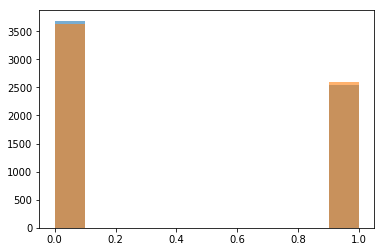

In [29]:
plt.hist(clf.predict(X['dev']), alpha=0.6)
plt.hist(clf_transformer(y['dev']), alpha=0.6)

plt.show()